# Sweeps - Capacitance matrix

### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.analyses.sweep_options.sweeping import Sweeping

In [3]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

In [4]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

In [5]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

### In this example, the design consists of 4 qubits and 4 CPWs.

In [6]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        a = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'c', 'Q2', 'b', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q2', 'c', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'c', 'Q4', 'b', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'c', '5.7 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

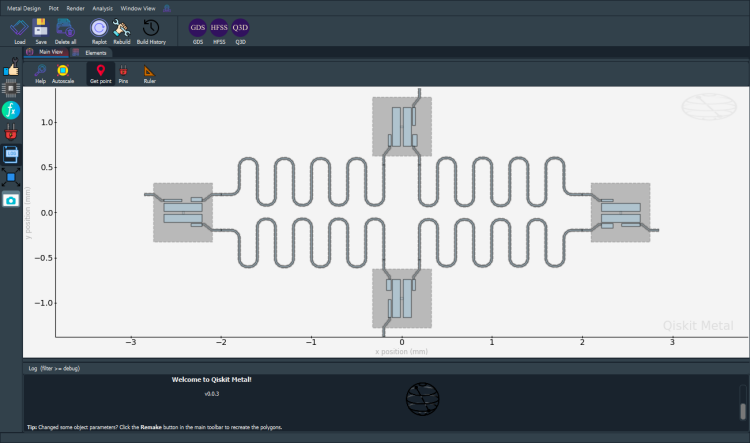

In [7]:
gui.screenshot()

## 2. Must open Ansys Q3D at this point.
### Registration occurs automatically within the method "sweep_one_option_get_capacitance_matrix". 

### Must have an open Ansys project and Q3D design before executing render_design. Can do it manually or automate it.

Manually: To create a new Ansys project, click "New", the leftmost icon right below the file menu. 

Automate: Use the cells below to open the Ansys application.  The method sweep_one_option_get_capacitance_matrix will connect to ansys, activate a q3d design, and add a setup.

In [8]:
q3d =  design.renderers.q3d

In [9]:
# This cell will open the Ansys application.  Run this cell, if Ansys, is not already open.
# A project will be opened using this command.
q3d.open_ansys()

In [10]:
render_design_argument_qcomps = ['Q2']
# pins a and b shorted to ground.
render_design_argument_endcaps = [('Q2', 'c')]

sweep = Sweeping(design)

In [11]:
# Pass a dict with arguments to be used add Setup to project.
# If you don't pass all the arguments, the default is determined by 
# QQ3DRenderer's default_options.

# The name of setup will be "Sweep_q3d_setup".  
# If a setup named "Sweep_q3d_setup" exists in the project, it will be deleted, 
# and a new setup will be added with the arguments from setup_args.
q3d_setup_args = Dict(freq_ghz=None,
                      save_fields=None,
                      enabled=None,
                      max_passes=None,
                      min_passes=None,
                      min_converged_passes=None,
                      percent_error=None,
                      percent_refinement=None,
                      auto_increase_solution_order=None,
                      solution_order=None,
                      solver_type=None)

# Example of updating the keys that we are interested in. 
q3d_setup_args = Dict(freq_ghz=5.6,
                      max_passes=9,
                      min_passes=2,
                      percent_error=0.45)

## 3 Metal pass information to Ansys through pyEPR, get capacitance matrix.
- Connect to Ansys Q3D.
- Rebuild QComponents in Metal.
- Render QComponents within Q3D and setup.
- Delete/Clear the Q3D between each calculation of capacitance  matrix.
- Calculate Capacitance matrix for each value in option_sweep.

#### Return a dict and return code.  If the return code is zero, there were no errors detected.  
#### The dict has:  key = each value used to sweep, value = capacitance matrix

#### This could take minutes based size of design.

In [12]:
#The argument "leave_last_design" is true by default.  

#Note: The method will connect to Ansys, activate_q3d_design(), add_q3d_setup().

all_sweeps, return_code = sweep.sweep_one_option_get_capacitance_matrix(
                                    q2.name, 
                                    'connection_pads.c.pad_width', 
                                    ['100um', '110um', '120um'],
                                    render_design_argument_qcomps, 
                                    render_design_argument_endcaps,
                                    setup_args = q3d_setup_args,
                                    design_name = "GetCapacitance")



INFO 02:45PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:45PM [load_ansys_project]: 	Opened Ansys App
INFO 02:45PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:45PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project16
INFO 02:45PM [connect_design]: No active design found (or error getting active design).
INFO 02:45PM [connect]: 	 Connected to project "Project16". No design detected
02:45PM 01s WARNING [activate_q3d_design]: The name=GetCapacitance was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 02:45PM [connect_design]: 	Opened active design
	Design:    GetCapacitance [Solution type: Q3D]
WARNING 02:45PM [connect_setup]: 	No design setup detected.
WARNING 02:45PM [connect_setup]: 	Creating Q3D default setup.
INFO 02:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:45PM [get_setup]: 	Opened setup `Sweep_q3d_setup

In [13]:
all_sweeps.keys()


dict_keys(['100um', '110um', '120um'])

In [14]:
# For each value of option, there is a set of data.
all_sweeps['100um'].keys()

dict_keys(['option_name', 'convergence_target', 'convergence_current', 'min_number_passes', 'is_convergence', 'capacitance', 'convergence_data'])

In [15]:
# Check for convergence for each value used in QComponent options.
if return_code ==0:
    print(f'{all_sweeps.keys()} \n')
    for key in all_sweeps.keys():
        print(f'\nkey={key}')
        is_converged = all_sweeps[key]['is_convergence']
        target = all_sweeps[key]['convergence_target']
        current = all_sweeps[key]['convergence_current']
        min_pass = all_sweeps[key]['min_number_passes']
        print(f'is_coverged={is_converged}')
        print(f'convergence_target={target}, convergence_current={current}')
        print(f'minimum_number_passes={min_pass}')
        
        option_name = all_sweeps[key]['option_name']
        print(f'option_name[\'{key}\'][\'option_name\']={option_name}')
        

dict_keys(['100um', '110um', '120um']) 


key=100um
is_coverged=True
convergence_target=0.45, convergence_current=0.29442
minimum_number_passes=2
option_name['100um']['option_name']=connection_pads.c.pad_width

key=110um
is_coverged=True
convergence_target=0.45, convergence_current=0.30596
minimum_number_passes=2
option_name['110um']['option_name']=connection_pads.c.pad_width

key=120um
is_coverged=True
convergence_target=0.45, convergence_current=0.28478
minimum_number_passes=2
option_name['120um']['option_name']=connection_pads.c.pad_width


In [16]:
# For example, just one capacitance matrix.
all_sweeps['100um']['capacitance']

,a_connector_pad_Q2,c_connector_pad_Q2,pad_bot_Q2,pad_top_Q2
a_connector_pad_Q2,205.74604,-36.66700,-53.29541,-54.24471
c_connector_pad_Q2,-36.66700,51.61032,-12.35697,-1.64007
pad_bot_Q2,-53.29541,-12.35697,99.14250,-31.13000
pad_top_Q2,-54.24471,-1.64007,-31.13000,89.76941


In [17]:
if return_code ==0:
    print(f'{all_sweeps.keys()} \n')
    for key in all_sweeps.keys():
        print(f'\nkey={key}')
        target = all_sweeps[key]['convergence_target']
        current = all_sweeps[key]['convergence_current']
        min_pass = all_sweeps[key]['min_number_passes']
        is_converged = all_sweeps[key]['is_convergence']
        
        print(f'minimum_number_passes={min_pass} \nis_coverged={is_converged}')
        print(f'convergence_target={target} \nconvergence_current={current}')
        option_name = all_sweeps[key]['option_name']
        print(f'option_name[\'{key}\'][\'option_name\']={option_name}')
        
        df_capacitance = all_sweeps[key]['capacitance']
        df_convergence = all_sweeps[key]['convergence_data']
        print('\ncapacitance dataframe:')
        print(df_capacitance)
        print('\nconvergence dataframe:')
        print(df_convergence)
        

dict_keys(['100um', '110um', '120um']) 


key=100um
minimum_number_passes=2 
is_coverged=True
convergence_target=0.45 
convergence_current=0.29442
option_name['100um']['option_name']=connection_pads.c.pad_width

capacitance dataframe:
                    a_connector_pad_Q2  c_connector_pad_Q2  pad_bot_Q2  \
a_connector_pad_Q2           205.74604           -36.66700   -53.29541   
c_connector_pad_Q2           -36.66700            51.61032   -12.35697   
pad_bot_Q2                   -53.29541           -12.35697    99.14250   
pad_top_Q2                   -54.24471            -1.64007   -31.13000   

                    pad_top_Q2  
a_connector_pad_Q2   -54.24471  
c_connector_pad_Q2    -1.64007  
pad_bot_Q2           -31.13000  
pad_top_Q2            89.76941  

convergence dataframe:
      # Triangle  Delta %
Pass                     
1            138      NaN
2            422  1.82530
3           1092  1.79550
4           1434  0.94777
5           1912  0.98674
6           2604  0.624

In [18]:
# In Q3d, after the last sweep, should the design be cleared?  The argument "leave_last_design" is true by default. 
# If you want to delete after last sweep, change argument to false.

leave_last_design = False
all_sweeps, return_code = sweep.sweep_one_option_get_capacitance_matrix(
                                q2.name, 
                                'connection_pads.c.pad_width', 
                                ['100um', '110um', '120um'],
                                render_design_argument_qcomps, 
                                render_design_argument_endcaps,
                                leave_last_design=leave_last_design,
                                setup_args = q3d_setup_args)

INFO 02:47PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:47PM [load_ansys_project]: 	Opened Ansys App
INFO 02:47PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:47PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project16
INFO 02:47PM [connect_design]: 	Opened active design
	Design:    GetCapacitance [Solution type: Q3D]
INFO 02:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:47PM [connect]: 	Connected to project "Project16" and design "GetCapacitance" 😀 

02:47PM 35s WARNING [activate_q3d_design]: The name=Sweep_Capacitance was not in active project.  A new design will be inserted to the project.  Names in active project are: 
['GetCapacitance'].  
INFO 02:47PM [connect_design]: 	Opened active design
	Design:    Sweep_Capacitance [Solution type: Q3D]
WARNING 02:47PM [connect_setup]: 	No design setup detected.
WARNING 02:47PM [connect_setup]: 	Creating Q3D default setup.
INFO 02:47

In [19]:
# Uncomment next line if you would like to close the gui
# gui.main_window.close()